### **Import necessary libraries**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

### **Load The Dataset**

In [ ]:
# Load the dataset
data = pd.read_excel('ML_dataset_performance_02.xlsx')

### **Correlation matrix**

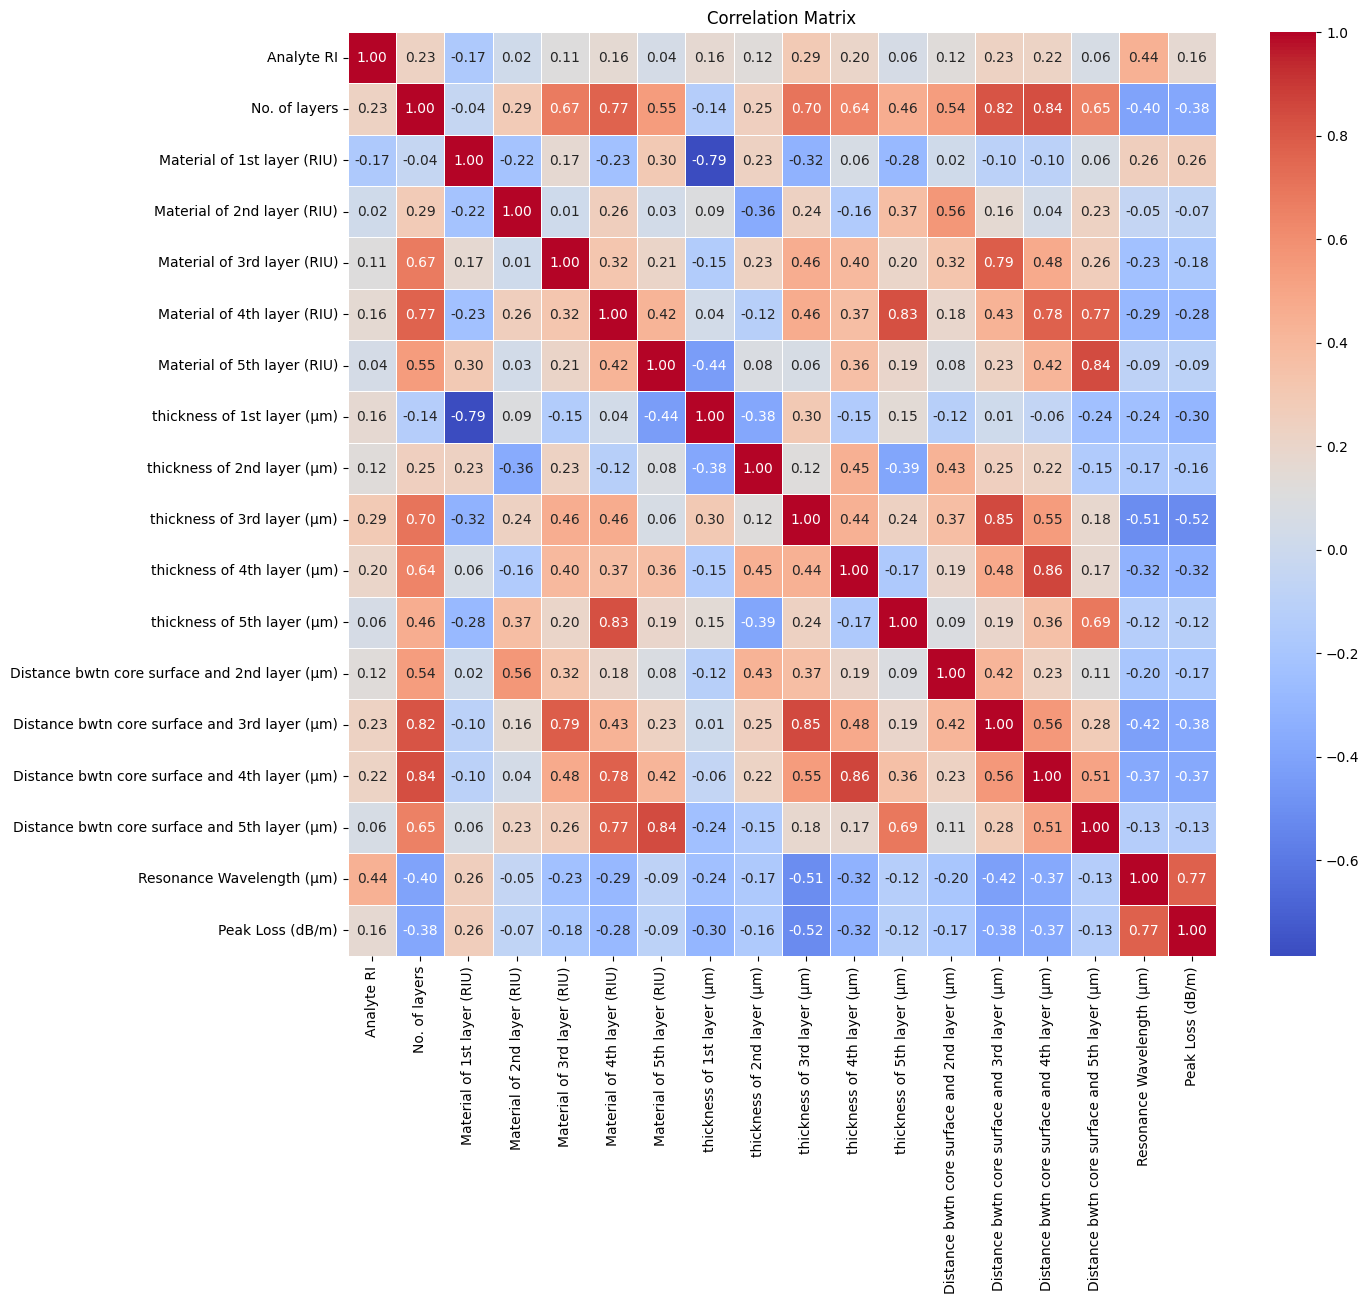

In [ ]:
correlation_matrix = data.corr()

# Plot as a heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')

# Save the figure as a TIFF file
#plt.savefig("Correlation_Matrix.tiff", format='tiff', dpi=300, bbox_inches='tight', pad_inches=0.5)
# pad_inches adds padding around the plot to prevent cropping

plt.show()

### **Separate Features and Target**

In [ ]:
X = data.drop(columns=["Resonance Wavelength (µm)", "Peak Loss (dB/m)"])
y = data[["Resonance Wavelength (µm)", "Peak Loss (dB/m)"]]

### **Log-Transform the Target**

In [ ]:
y_transformed = np.log1p(y)  # log(1 + y) handles any potential zeros
#y_transformed = scaler.fit_transform(y.values.reshape(-1, 1))

### **Standardize the Features**

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#y_transformed = scaler.fit_transform(y.values.reshape(-1, 1))

### **Split the Data into Training and Testing Sets**

In [ ]:
from sklearn.model_selection import train_test_split

#(Logged) Split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_transformed, test_size=0.2, random_state=42)

#(Standerd) Optional: Check the shapes
print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set shape: X_test={X_test.shape}, y_test={y_test.shape}")

Training set shape: X_train=(196, 16), y_train=(196, 2)
Testing set shape: X_test=(49, 16), y_test=(49, 2)


### **Train a baseline XGBoost model with default parameters**

In [ ]:
# Wrap XGBoost with MultiOutputRegressor to handle the two targets.
baseline_model = MultiOutputRegressor(
    xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
)
baseline_model.fit(X_train, y_train) # Changed line: fit on training data
baseline_pred = baseline_model.predict(X_test) # Changed line: predict on test data

### **Evaluate baseline model (Logged)**

In [ ]:
# Evaluate baseline model
baseline_mse = mean_squared_error(y_test, baseline_pred)
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(baseline_mse)
baseline_r2 = r2_score(y_test, baseline_pred)

# Get individual target predictions and true values
resonance_wavelength_pred = baseline_pred[:, 0]  # Predictions for Resonance Wavelength
peak_loss_pred = baseline_pred[:, 1]  # Predictions for Peak Loss

resonance_wavelength_true = y_test['Resonance Wavelength (µm)']  # True values for Resonance Wavelength
peak_loss_true = y_test['Peak Loss (dB/m)']  # True values for Peak Loss


# Calculate metrics for Resonance Wavelength
resonance_wavelength_mse = mean_squared_error(resonance_wavelength_true, resonance_wavelength_pred)
resonance_wavelength_mae = mean_absolute_error(resonance_wavelength_true, resonance_wavelength_pred)
resonance_wavelength_rmse = np.sqrt(resonance_wavelength_mse)
resonance_wavelength_r2 = r2_score(resonance_wavelength_true, resonance_wavelength_pred)

# Calculate metrics for Peak Loss
peak_loss_mse = mean_squared_error(peak_loss_true, peak_loss_pred)
peak_loss_mae = mean_absolute_error(peak_loss_true, peak_loss_pred)
peak_loss_rmse = np.sqrt(peak_loss_mse)
peak_loss_r2 = r2_score(peak_loss_true, peak_loss_pred)

# Print the metrics for each target
print("Baseline XGBoost Model Performance (Resonance Wavelength):")
print(f"MSE: {resonance_wavelength_mse:.4f}")
print(f"MAE: {resonance_wavelength_mae:.4f}")
print(f"RMSE: {resonance_wavelength_rmse:.4f}")
print(f"R²: {resonance_wavelength_r2:.4f}")

print("\nBaseline XGBoost Model Performance (Peak Loss):")
print(f"MSE: {peak_loss_mse:.4f}")
print(f"MAE: {peak_loss_mae:.4f}")
print(f"RMSE: {peak_loss_rmse:.4f}")
print(f"R²: {peak_loss_r2:.4f}")

Baseline XGBoost Model Performance (Resonance Wavelength):
MSE: 0.0010
MAE: 0.0217
RMSE: 0.0309
R²: 0.9654

Baseline XGBoost Model Performance (Peak Loss):
MSE: 0.0313
MAE: 0.0938
RMSE: 0.1769
R²: 0.9395


### **Define the XGBoost model for tuning**

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the XGBoost model for tuning (wrapped in MultiOutputRegressor)
xgb_model = MultiOutputRegressor(
    xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
)

# Define a smaller parameter grid for GridSearchCV
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__learning_rate': [0.05, 0.1, 0.2],
    'estimator__max_depth': [3, 5, 7],
    'estimator__subsample': [0.8, 1.0],
    'estimator__colsample_bytree': [0.8, 1.0]
}


# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use appropriate scoring metric
    cv=5,  # Number of cross-validation folds
    verbose=2,  # Display progress
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model and hyperparameters
best_xgb = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best hyperparameters found by GridSearchCV:")
for key, value in best_params.items():
    print(f"{key}: {value}")

# ... (The rest of your code for evaluation and comparison can remain the same) ...

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best hyperparameters found by GridSearchCV:
estimator__colsample_bytree: 0.8
estimator__learning_rate: 0.1
estimator__max_depth: 5
estimator__n_estimators: 300
estimator__subsample: 0.8


### **Get the best model**

In [ ]:
# Get the best model from GridSearchCV
best_xgb = grid_search.best_estimator_

# Make predictions with the best model
best_pred = best_xgb.predict(X_test)

# Function to evaluate and print metrics for a given target
def evaluate_and_print_metrics(target_name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{target_name} Performance:")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    return r2  # Return R² for comparison

# Evaluate and print metrics for both targets for baseline model
baseline_r2_resonance = evaluate_and_print_metrics(
    "Baseline XGBoost Model (Resonance Wavelength)",
    y_test['Resonance Wavelength (µm)'],
    baseline_pred[:, 0]
)
baseline_r2_peak_loss = evaluate_and_print_metrics(
    "Baseline XGBoost Model (Peak Loss)",
    y_test['Peak Loss (dB/m)'],
    baseline_pred[:, 1]
)

# Evaluate and print metrics for both targets for tuned model
tuned_r2_resonance = evaluate_and_print_metrics(
    "Tuned XGBoost Model (Resonance Wavelength)",
    y_test['Resonance Wavelength (µm)'],
    best_pred[:, 0]
)
tuned_r2_peak_loss = evaluate_and_print_metrics(
    "Tuned XGBoost Model (Peak Loss)",
    y_test['Peak Loss (dB/m)'],
    best_pred[:, 1]
)

# Compare baseline and tuned models for each target
print("\nModel Comparison (Resonance Wavelength):")
print(f"Baseline XGBoost R²: {baseline_r2_resonance:.4f}")
print(f"Tuned XGBoost R²: {tuned_r2_resonance:.4f}")
improvement_resonance = (tuned_r2_resonance - baseline_r2_resonance) / baseline_r2_resonance * 100
print(f"Improvement: {improvement_resonance:.2f}%")

print("\nModel Comparison (Peak Loss):")
print(f"Baseline XGBoost R²: {baseline_r2_peak_loss:.4f}")
print(f"Tuned XGBoost R²: {tuned_r2_peak_loss:.4f}")
improvement_peak_loss = (tuned_r2_peak_loss - baseline_r2_peak_loss) / baseline_r2_peak_loss * 100
print(f"Improvement: {improvement_peak_loss:.2f}%")


Baseline XGBoost Model (Resonance Wavelength) Performance:
MSE: 0.0010
MAE: 0.0217
RMSE: 0.0309
R²: 0.9654

Baseline XGBoost Model (Peak Loss) Performance:
MSE: 0.0313
MAE: 0.0938
RMSE: 0.1769
R²: 0.9395

Tuned XGBoost Model (Resonance Wavelength) Performance:
MSE: 0.0007
MAE: 0.0186
RMSE: 0.0256
R²: 0.9762

Tuned XGBoost Model (Peak Loss) Performance:
MSE: 0.0361
MAE: 0.0993
RMSE: 0.1899
R²: 0.9303

Model Comparison (Resonance Wavelength):
Baseline XGBoost R²: 0.9654
Tuned XGBoost R²: 0.9762
Improvement: 1.11%

Model Comparison (Peak Loss):
Baseline XGBoost R²: 0.9395
Tuned XGBoost R²: 0.9303
Improvement: -0.98%


### **Visualize feature importance**

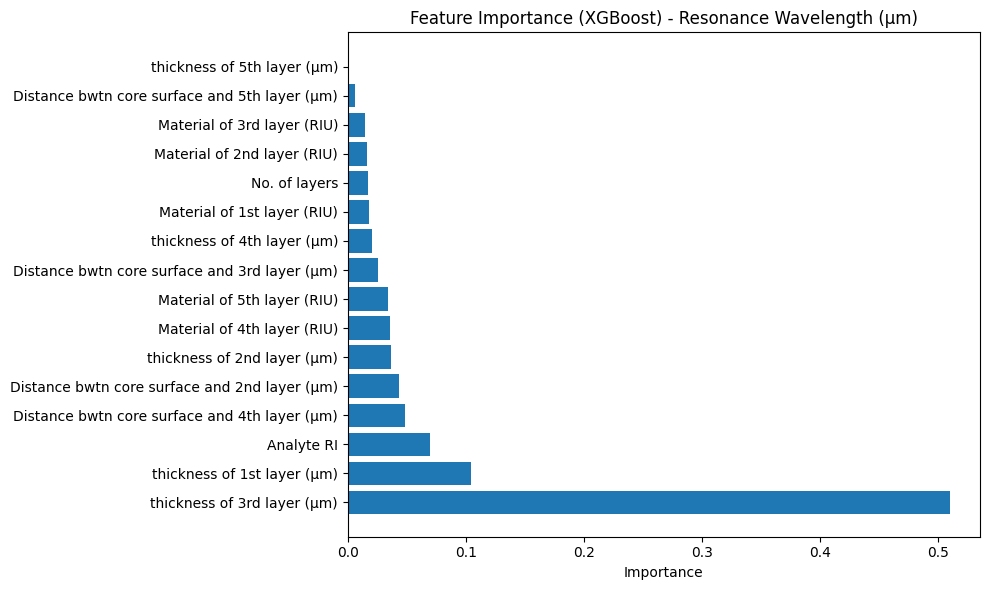

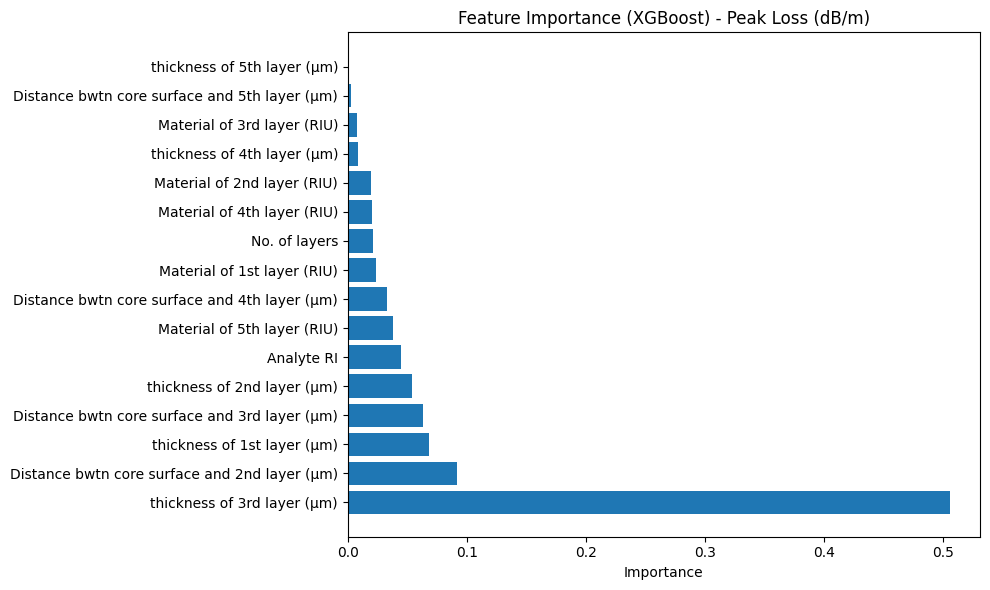

In [ ]:
# Visualize feature importance for each target

# Get the names of the target variables
target_names = y.columns

# Iterate through each target and its corresponding estimator
for i, target_name in enumerate(target_names):
    # Access the feature_importances_ from the i-th individual estimator
    importances = best_xgb.estimators_[i].feature_importances_
    feature_names = X.columns
    sorted_idx = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.barh(feature_names[sorted_idx], importances[sorted_idx])
    plt.title(f'Feature Importance (XGBoost) - {target_name}')
    plt.xlabel('Importance')
    plt.tight_layout()

    # Save the figure before showing it
    # Sanitize the target name to remove characters invalid in filenames, like '/'
    sanitized_target_name = target_name.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
    #plt.savefig(f"Feature Importance (XGBoost) - {sanitized_target_name}.tiff", format='tiff', dpi=300, bbox_inches='tight', pad_inches=0.5)

    plt.show()

### **Plot actual vs predicted values**

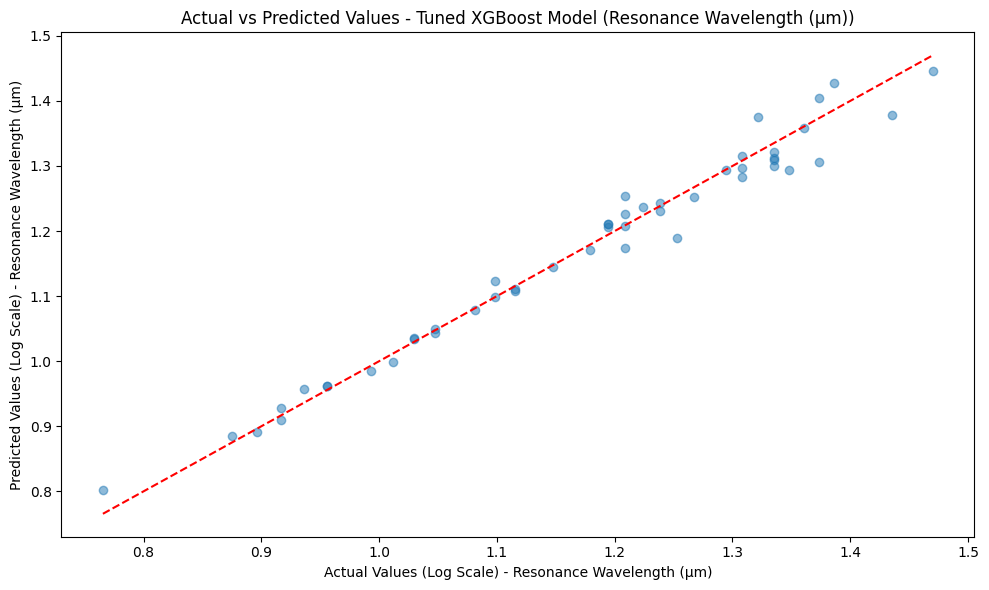

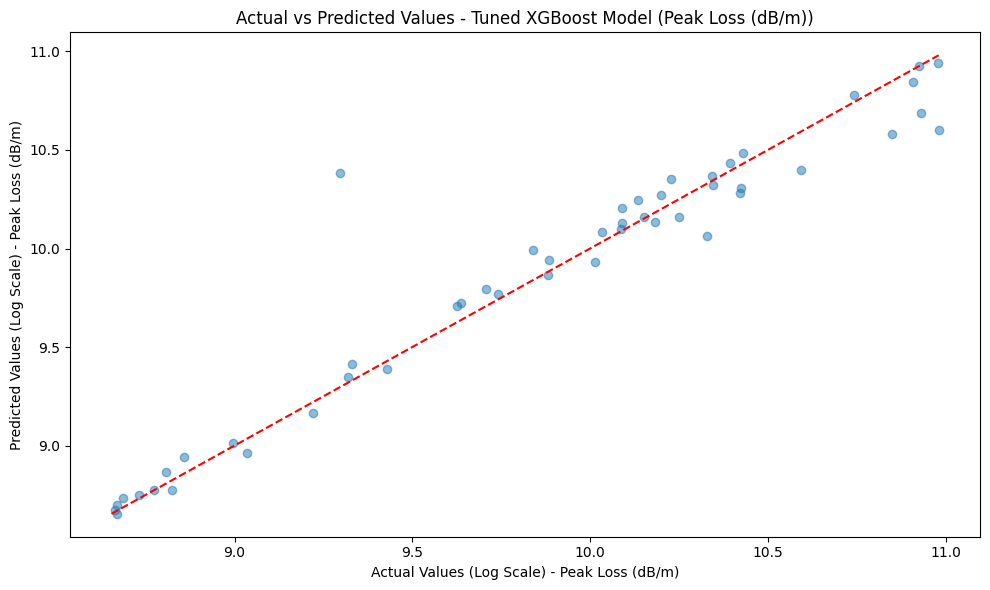

In [ ]:
# Plot actual vs predicted values for each target

# Get the names of the target variables
target_names = y_test.columns

# Iterate through each target
for i, target_name in enumerate(target_names):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test[target_name], best_pred[:, i], alpha=0.5)

    # Add a line representing perfect prediction
    min_val = min(y_test[target_name].min(), best_pred[:, i].min())
    max_val = max(y_test[target_name].max(), best_pred[:, i].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.xlabel(f'Actual Values (Log Scale) - {target_name}')
    plt.ylabel(f'Predicted Values (Log Scale) - {target_name}')
    plt.title(f'Actual vs Predicted Values - Tuned XGBoost Model ({target_name})')
    plt.tight_layout()

    # Save the figure before showing it
    # Sanitize the target name to remove characters invalid in filenames
    sanitized_target_name = target_name.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
    #plt.savefig(f"actual_vs_predicted (xgboost) - {sanitized_target_name}.tiff", format='tiff', dpi=300, bbox_inches='tight', pad_inches=0.5)

    plt.show()

### **Save the best model**

In [ ]:
import joblib
joblib.dump(best_xgb, 'best_xgboost_model.pkl')
print("\nBest model saved as 'best_xgboost_model.pkl'")


Best model saved as 'best_xgboost_model.pkl'


### **Plot the learning curves for the best model (Optional)**

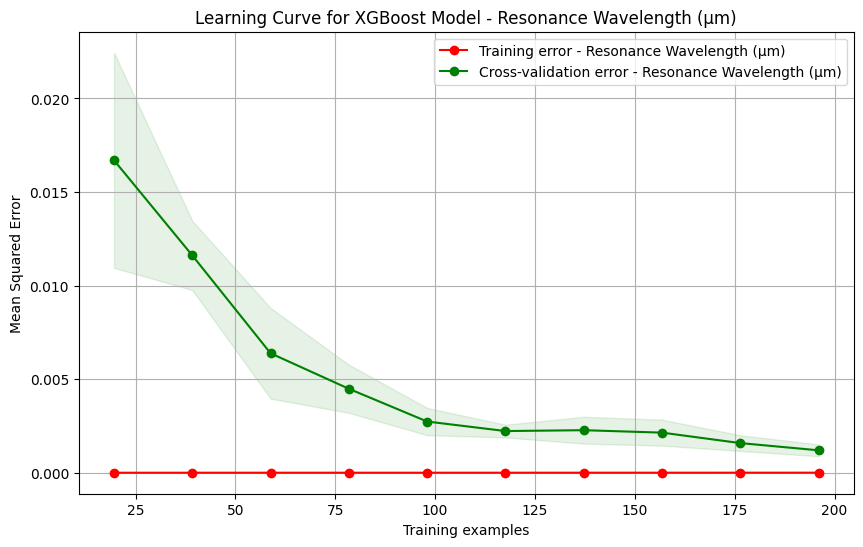

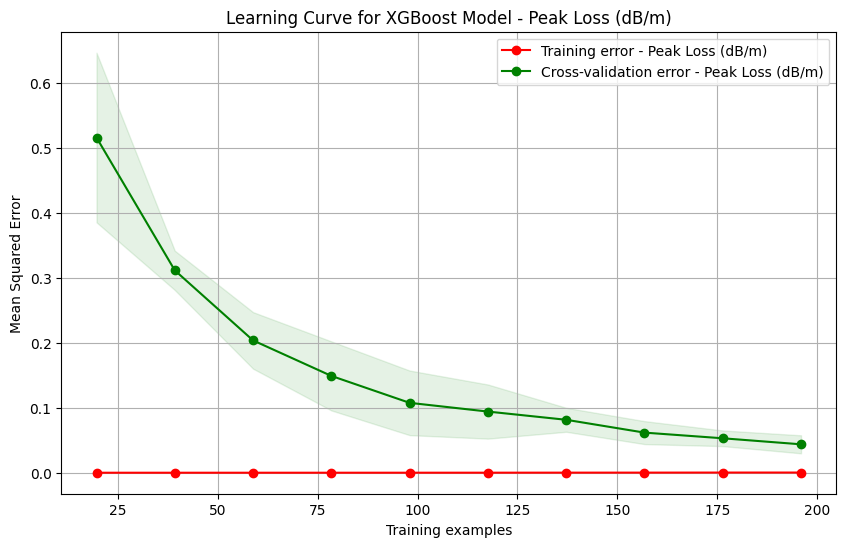

In [ ]:
# Optional: Plot the learning curves for the best model for each target
from sklearn.model_selection import learning_curve, KFold
from sklearn.metrics import mean_squared_error

# Get the names of the target variables
target_names = y_train.columns
n_targets = len(target_names)

# Define training sizes
train_sizes = np.linspace(0.1, 1.0, 10)
n_train_sizes = len(train_sizes)

# Initialize arrays to store scores for each target
train_scores_targets = np.zeros((n_train_sizes, 5, n_targets)) # 5 folds, n_targets
test_scores_targets = np.zeros((n_train_sizes, 5, n_targets))

# Get the base estimator from the MultiOutputRegressor
base_estimator = best_xgb.estimator

# Perform K-Fold cross-validation manually
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    for i, train_size_frac in enumerate(train_sizes):
        # Select a subset of the training data
        n_samples = int(train_size_frac * len(X_train_fold))
        if n_samples == 0:
            continue # Skip if no samples

        X_subset = X_train_fold[:n_samples]
        y_subset = y_train_fold.iloc[:n_samples]

        # Train a separate model for each target on the subset
        for j, target_name in enumerate(target_names):
            # Create a new instance of the base estimator for each target
            estimator = base_estimator.__class__(**base_estimator.get_params())

            # Train the estimator on the subset for the specific target
            estimator.fit(X_subset, y_subset[target_name])

            # Evaluate on the training subset
            y_train_pred = estimator.predict(X_subset)
            train_scores_targets[i, fold, j] = mean_squared_error(y_subset[target_name], y_train_pred)

            # Evaluate on the test fold
            y_test_pred = estimator.predict(X_test_fold)
            test_scores_targets[i, fold, j] = mean_squared_error(y_test_fold[target_name], y_test_pred)

# Calculate mean and std for each target's scores
train_mean_targets = np.mean(train_scores_targets, axis=1)
train_std_targets = np.std(train_scores_targets, axis=1)
test_mean_targets = np.mean(test_scores_targets, axis=1)
test_std_targets = np.std(test_scores_targets, axis=1)

# Plot learning curves for each target
for j, target_name in enumerate(target_names):
    plt.figure(figsize=(10, 6))
    plt.plot(len(X_train) * train_sizes, train_mean_targets[:, j], 'o-', color='r', label=f'Training error - {target_name}')
    plt.plot(len(X_train) * train_sizes, test_mean_targets[:, j], 'o-', color='g', label=f'Cross-validation error - {target_name}')
    plt.fill_between(len(X_train) * train_sizes, train_mean_targets[:, j] - train_std_targets[:, j], train_mean_targets[:, j] + train_std_targets[:, j], alpha=0.1, color='r')
    plt.fill_between(len(X_train) * train_sizes, test_mean_targets[:, j] - test_std_targets[:, j], test_mean_targets[:, j] + test_std_targets[:, j], alpha=0.1, color='g')
    plt.xlabel('Training examples')
    plt.ylabel('Mean Squared Error')
    plt.title(f'Learning Curve for XGBoost Model - {target_name}')
    plt.legend(loc='best')
    plt.grid(True)

    # Save the figure before showing it
    sanitized_target_name = target_name.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
    #plt.savefig(f"learning_curve (xgboost_logged) - {sanitized_target_name}.tiff", format='tiff', dpi=300, bbox_inches='tight', pad_inches=0.5)

    plt.show()

### **Figure Plotting**

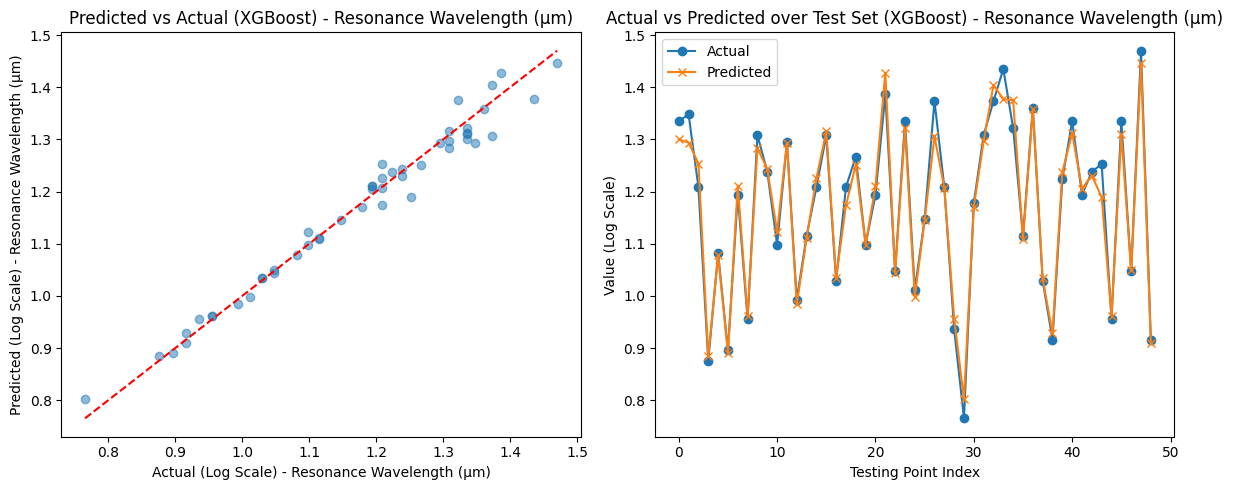

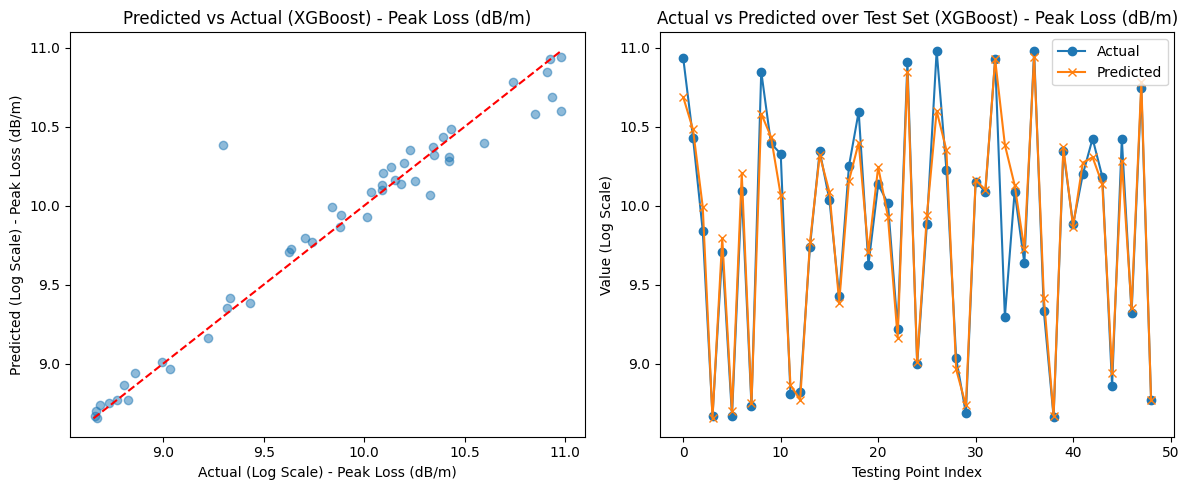

In [ ]:
# Get the names of the target variables
target_names = y_test.columns

# Get the predictions from the best model
best_pred = best_xgb.predict(X_test)

# Iterate through each target
for i, target_name in enumerate(target_names):
    plt.figure(figsize=(12, 5))

    # Plot 1: Scatter plot of Actual vs Predicted
    plt.subplot(1, 2, 1)
    plt.scatter(y_test[target_name], best_pred[:, i], alpha=0.5)

    # Add a line representing perfect prediction
    min_val = min(y_test[target_name].min(), best_pred[:, i].min())
    max_val = max(y_test[target_name].max(), best_pred[:, i].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.xlabel(f'Actual (Log Scale) - {target_name}')
    plt.ylabel(f'Predicted (Log Scale) - {target_name}')
    plt.title(f'Predicted vs Actual (XGBoost) - {target_name}')

    # Plot 2: Line plot of Actual vs Predicted over testing points
    plt.subplot(1, 2, 2)
    plt.plot(y_test[target_name].values, label='Actual', marker='o')
    plt.plot(best_pred[:, i], label='Predicted', marker='x')
    plt.xlabel('Testing Point Index') # Changed label for clarity
    plt.ylabel('Value (Log Scale)')
    plt.title(f'Actual vs Predicted over Test Set (XGBoost) - {target_name}')
    plt.legend()

    plt.tight_layout()

    # Save the figure before showing it
    sanitized_target_name = target_name.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
   # plt.savefig(f"figure_plot (xgboost_Logged) - {sanitized_target_name}.tiff", format='tiff', dpi=300, bbox_inches='tight', pad_inches=0.5)

    plt.show()